# Introduction

This is the analysis of gut intestinal stem cell data as presented in Böttcher et al. We use in total **75,012** cells from **14 samples** in **6 conditions** (2 replicates in each mutant, 3 replicates in each control and 1 sample FVR only controls):

* Control (whole crypt)
* Control (FVR enriched)
* Control (FVR only)
* Mutant (Fltp deficient, whole crypt)
* Mutant (Fltp deficient, FVR enriched)
* Control (High fat diet project)

In this notebook, data are not batch effect corrected.

We filtered cells by

* number of reads
* number of detected genes
* fraction of mitochondrial reads (< 10%) 


## Tasks in this notebook

In order to keep the notebook structure short and well-arranged, we have split the gut intestinal stem cell analysis into several parts:

1. Pre-processing and filtering
2. Preparation of Batch effect correction
3. Batch effect correction with adjusted Combat


This notebook covers **part 3**.

# Initialise scanpy


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc
import matplotlib as mpl
import anndata as ann
#import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
import scipy as sci
import os

sc.settings.verbosity = 3                # amount of output
sc.settings.set_figure_params(dpi=150, color_map='RdYlBu_r')
sc.logging.print_version_and_date()

Running Scanpy 1.3.1 on 2021-01-22 14:39.


# Batch Effect Correction with adjusted ComBat

Load combat.py before applying it:

In [9]:
%run '~/Documents/Python/maren_codes/combat'

Let us prepare all variables to run ComBat. 

**As a note:** Instead of using `Control_7_FVR_only` and `Control_5_FVR` as batch separate variables in batch 2, we use only `Control_7_FVR_only`. The reason is that both batches tend to be separated pretty well by the batch correction when we used separate variables. However, this is most certainly an artifact of batch correction as both samples come from the same mouse and clustered together very nicely before correction, which we aim to preserve.

## Load data

In [2]:
adata_merge = sc.read('./../data/downsampled_data_AB_AL_n.h5')
adata_out = sc.read('./../data/downsampled_out_data_AB_AL_n.h5')

In [5]:
adata = sc.read('./../data/gut_AB_AL_all.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 72290 × 14941 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'batch', 'doublet_score', 'doublet', 'louvain'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

Prepare input for custom ComBat function.

In [62]:
data = pd.DataFrame(adata_merge.X.todense())
batch = pd.Series(adata_merge.obs['sample'])
batch = batch.reset_index()
data2 = pd.DataFrame(adata_out.X.todense())
#batch2 = pd.Series(adata_out.obs['sample'])
batch2 = pd.Series(np.repeat('Control_5_FVR',len(adata_out.obs['sample'])), 
                   name='sample')
batch2 = batch2.reset_index()


Run Combat.

In [63]:
data_cor = combat(data=data.T,batch=batch['sample'], 
                  data2= data2.T, batch2=batch2['sample'])

found 14 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


found 1 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing additional Data across genes.


Adjusting additional data


Reset zero values:

In [64]:
ix_zero = data==0
ix_zero2 = data2==0

In [65]:
ix_zeros =np.concatenate([ix_zero, ix_zero2], axis=0)

In [66]:
data_cor.T[ix_zeros]=0 

Free some space by deleting the dense matrices `data` and `data2`.

In [67]:
del data
del data2

Let us construct a new corrected `anndata` object.

In [68]:
adata_log_cor = ann.AnnData(X=sci.sparse.csr_matrix(data_cor.T))
adata_log_cor.var_names = adata_merge.var_names
adata_log_cor.obs['sample'] = np.concatenate([adata_merge.obs['sample'], 
                                              adata_out.obs['sample']])
adata_log_cor.obs.index = np.concatenate([adata_merge.obs.index, 
                                          adata_out.obs.index])

Add some pieces of information to the corrected data object.

In [69]:
adata_log_cor.obs['percent_mito'] = np.concatenate([adata_merge.obs['percent_mito'], 
                                                    adata_out.obs['percent_mito']])
adata_log_cor.obs['percent_ribo'] = np.concatenate([adata_merge.obs['percent_ribo'], 
                                                    adata_out.obs['percent_ribo']])
adata_log_cor.obs['n_counts'] = np.concatenate([adata_merge.obs['n_counts'], 
                                                adata_out.obs['n_counts']])
adata_log_cor.obs['n_genes'] = np.concatenate([adata_merge.obs['n_genes'], 
                                               adata_out.obs['n_genes']])

Get `mutant` and `control` state such that we can split the data into the respective part later on.

In [70]:
mutantM = np.in1d(adata_merge.obs['sample'], 
                  ['Mutant_1', 'Mutant_2', 'Mutant_3_FVR', 'Mutant_4_FVR'])
mutantO = np.in1d(adata_out.obs['sample'], 
                  ['Mutant_1', 'Mutant_2', 'Mutant_3_FVR', 'Mutant_4_FVR'])
mutant = np.concatenate([mutantM, mutantO])

In [71]:
adata_log_cor.obs['genetics'] = pd.Series(pd.Categorical.from_codes(mutant, 
                                          categories= ['control', 'mutant'])).values


In [72]:
pd.crosstab( adata_log_cor.obs['sample'],adata_log_cor.obs['genetics'])

genetics            control  mutant
sample                             
CD_1                   5216       0
CD_2                   5232       0
CD_3                   4988       0
Control_1              3828       0
Control_2              3136       0
Control_3_FVR          4391       0
Control_4_FVR          5075       0
Control_5_FVR          8856       0
Control_6              7059       0
Control_7_FVR_only     8511       0
Mutant_1                  0    3819
Mutant_2                  0    3932
Mutant_3_FVR              0    3857
Mutant_4_FVR              0    4390

Make sure that the indexes of the samples are the same for the `raw` object and the main data set.

In [73]:
adata_log_cor = adata_log_cor[np.argsort(adata_log_cor.obs.index)]

In [74]:
adata_log_cor.raw = adata[np.argsort(adata.obs.index)]

In [75]:
adata_log_cor

AnnData object with n_obs × n_vars = 72290 × 14941 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'genetics'

## Visualise ComBat-zeroFix corrected data

After correcting for batch effects, we compute PCA and tSNE visualisations to 'check' for batch effects. 

In [76]:
sc.tl.pca(adata_log_cor)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


... storing 'sample' as categorical


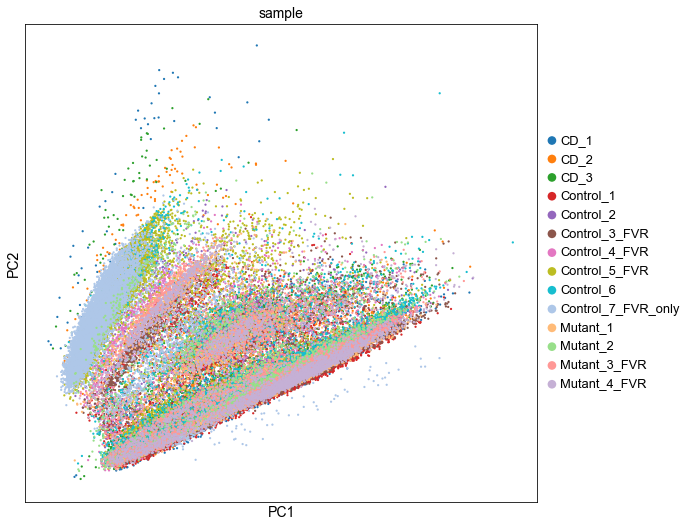

In [77]:
rcParams['figure.figsize']=(8,8)
sc.pl.pca(adata_log_cor, color='sample',size=20)

In [78]:
sc.pp.neighbors(adata_log_cor)
sc.tl.umap(adata_log_cor)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:27.09) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:01:06.68) --> added
    'X_umap', UMAP coordinates (adata.obsm)


We will use the raw gene expression for visualisation.

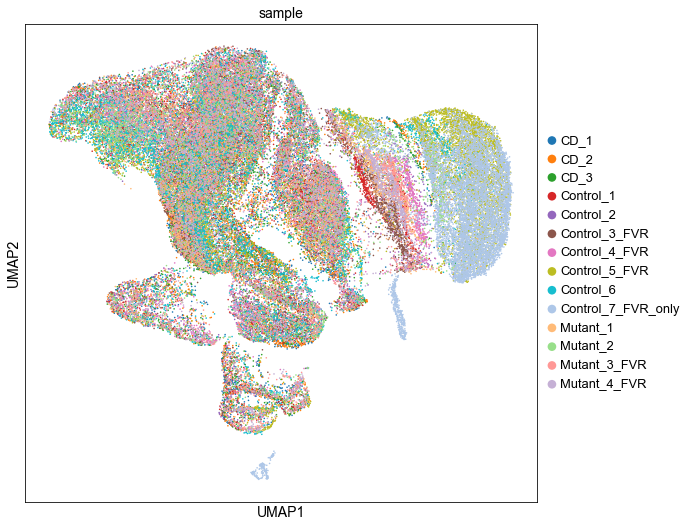

In [79]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata_log_cor, color='sample', size=10)

In [80]:
adata_log_cor

AnnData object with n_obs × n_vars = 72290 × 14941 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'genetics'
    uns: 'pca', 'sample_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

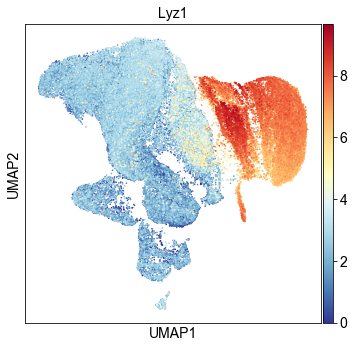

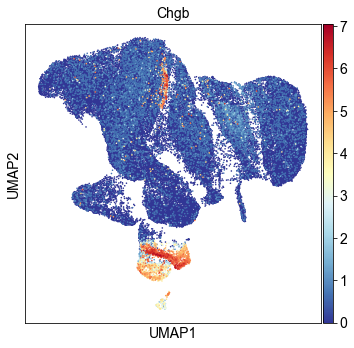

In [81]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_log_cor, color='Lyz1', color_map='RdYlBu_r', size=10)
sc.pl.umap(adata_log_cor, color='Chgb', color_map='RdYlBu_r', size=10)

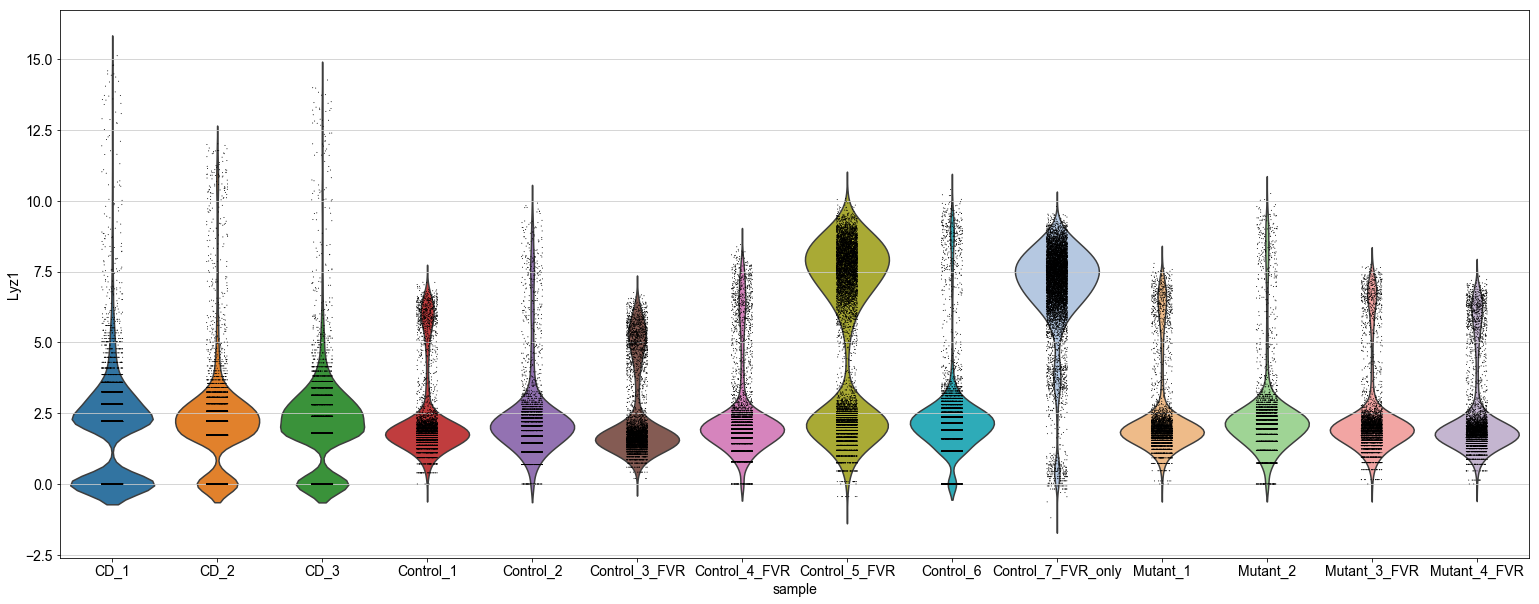

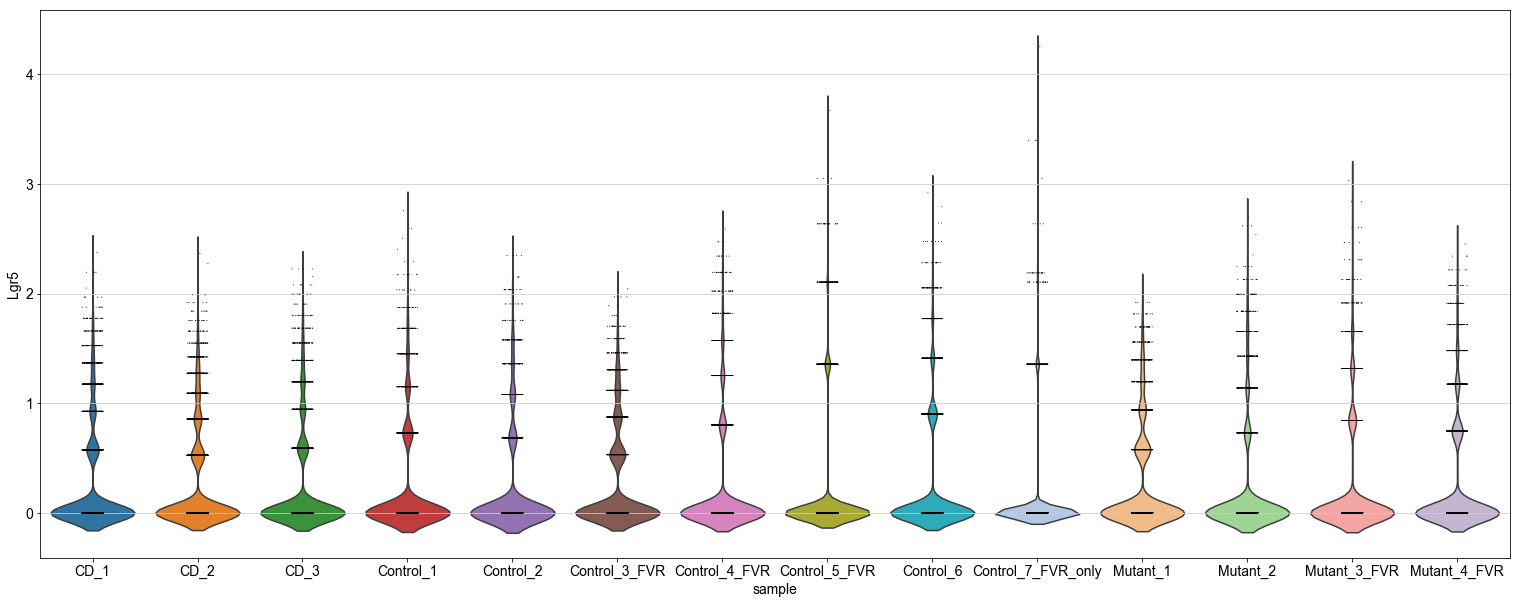

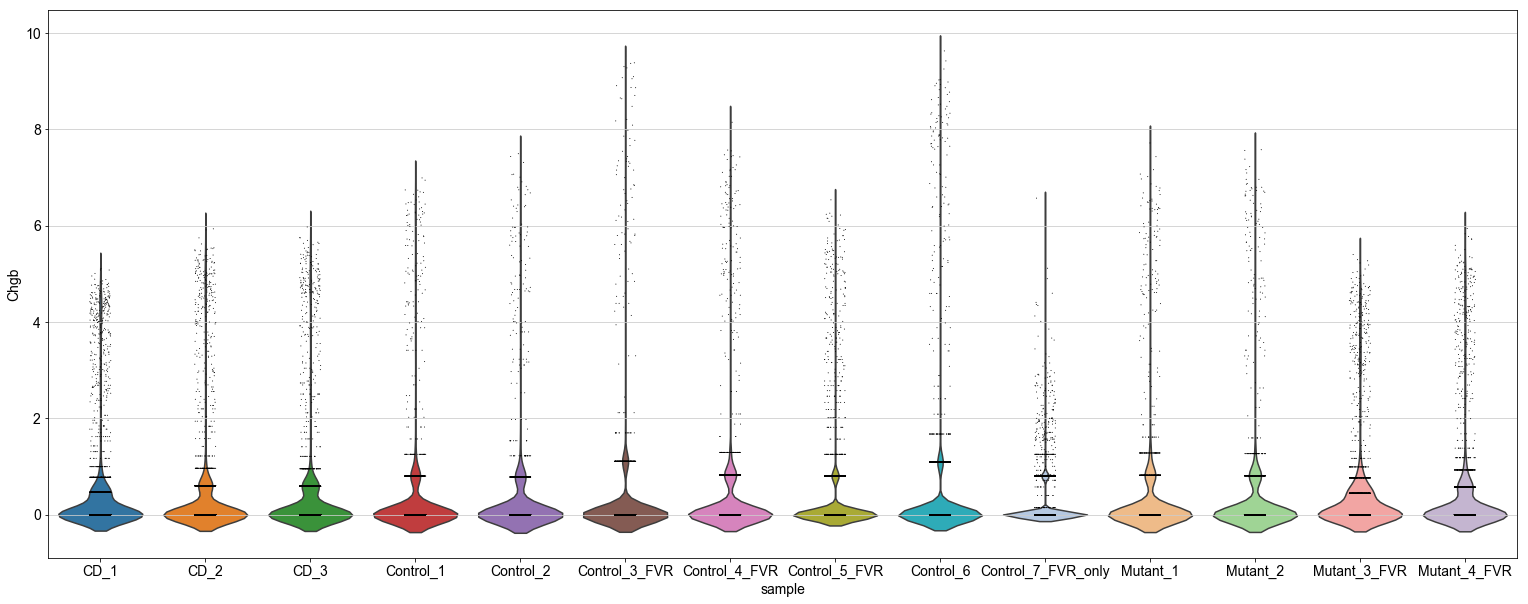

In [82]:
rcParams['figure.figsize']=(20,10)
sc.pl.violin(adata_log_cor, use_raw=False, keys='Lyz1', groupby='sample')
sc.pl.violin(adata_log_cor, use_raw=False, keys='Lgr5', groupby='sample')
sc.pl.violin(adata_log_cor, use_raw=False, keys='Chgb', groupby='sample')

# Filter genes and repeat visualisation

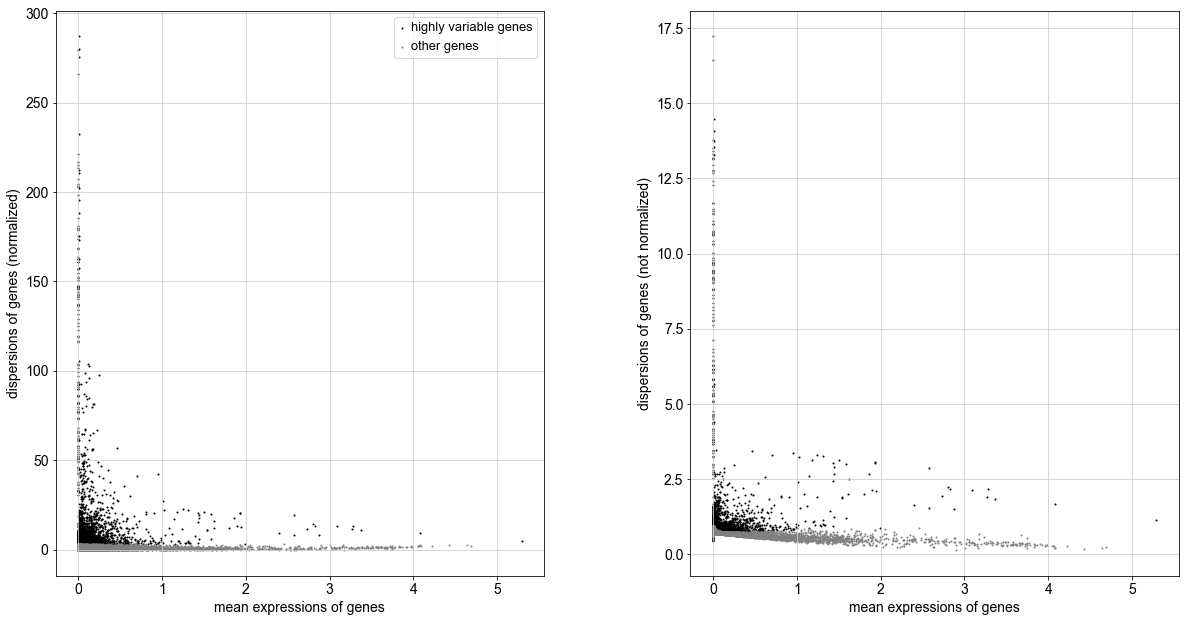

In [83]:
result = sc.pp.filter_genes_dispersion(adata_log_cor.X, 
                                       flavor='cell_ranger', 
                                       log=False, n_top_genes=2000)
rcParams['figure.figsize']=(10,10)
sc.pl.filter_genes_dispersion(result)
adata_hvg = adata_log_cor[:, result.gene_subset]
adata_hvg.var['mean'] = result.means[result.gene_subset]
adata_hvg.var['dispersion'] = result.dispersions[result.gene_subset]

In [84]:
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:25.40) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:01:03.66) --> added
    'X_umap', UMAP coordinates (adata.obsm)


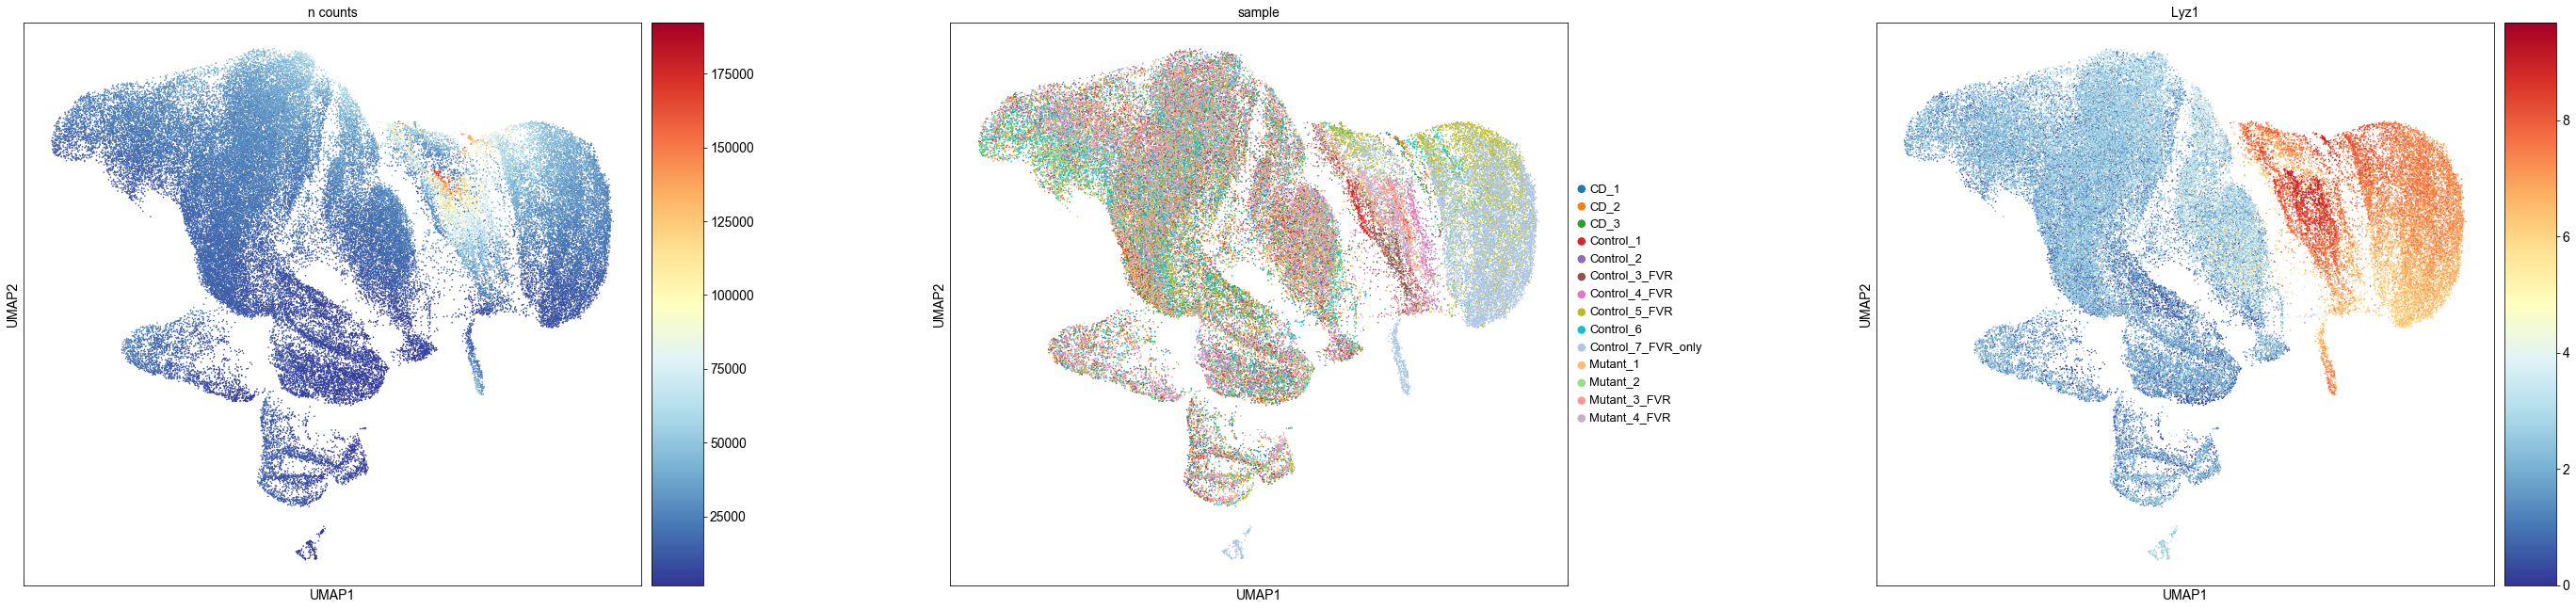

In [85]:
sc.pl.umap(adata_hvg, color=['n_counts', 'sample', 'Lyz1'], size=10)

In [86]:
sc.pp.normalize_per_cell(adata_hvg,key_n_counts='n_counts', 
                         counts_per_cell_after=10e4)

In [87]:
sc.tl.pca(adata_hvg)
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:26.94) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:01:05.00) --> added
    'X_umap', UMAP coordinates (adata.obsm)


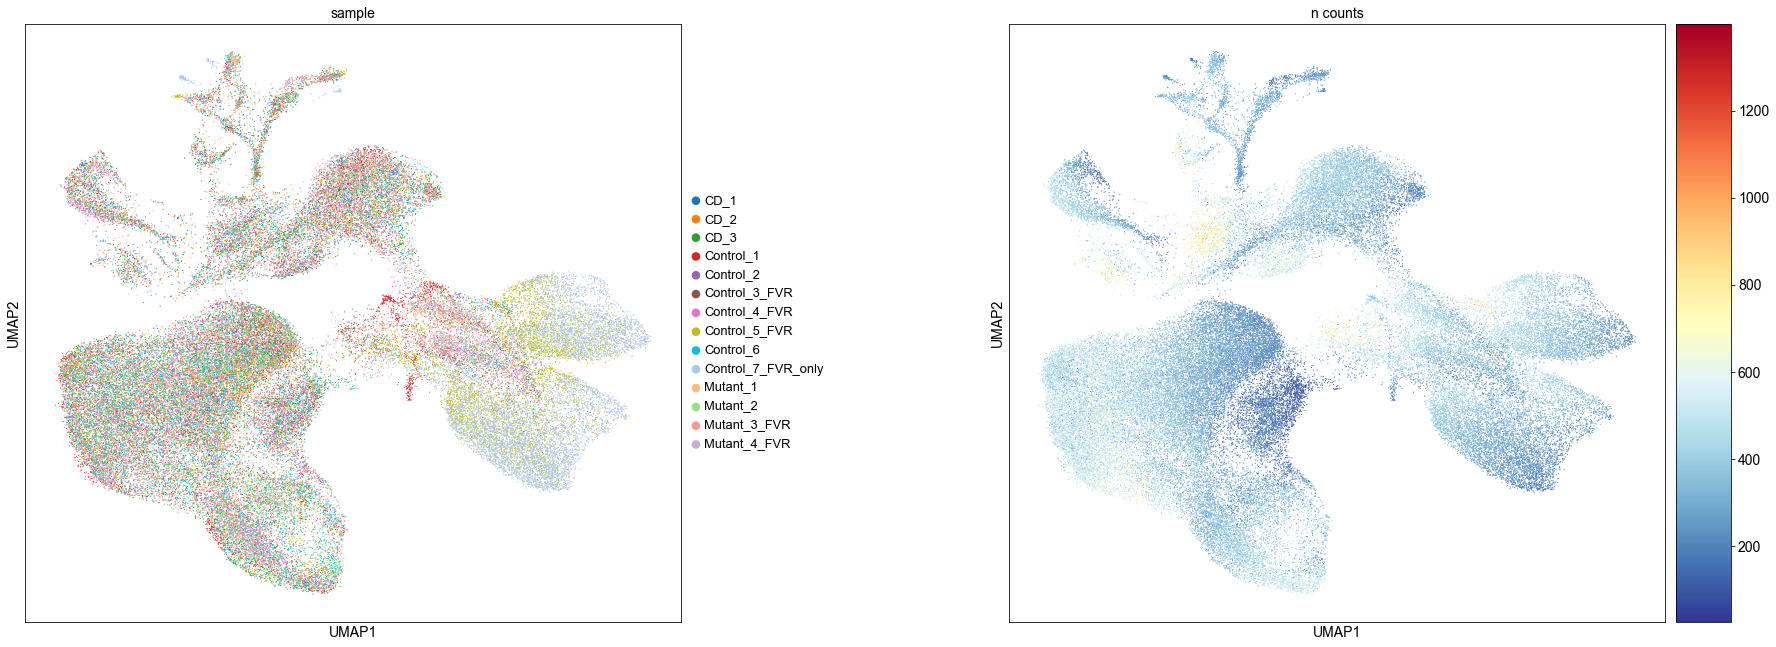

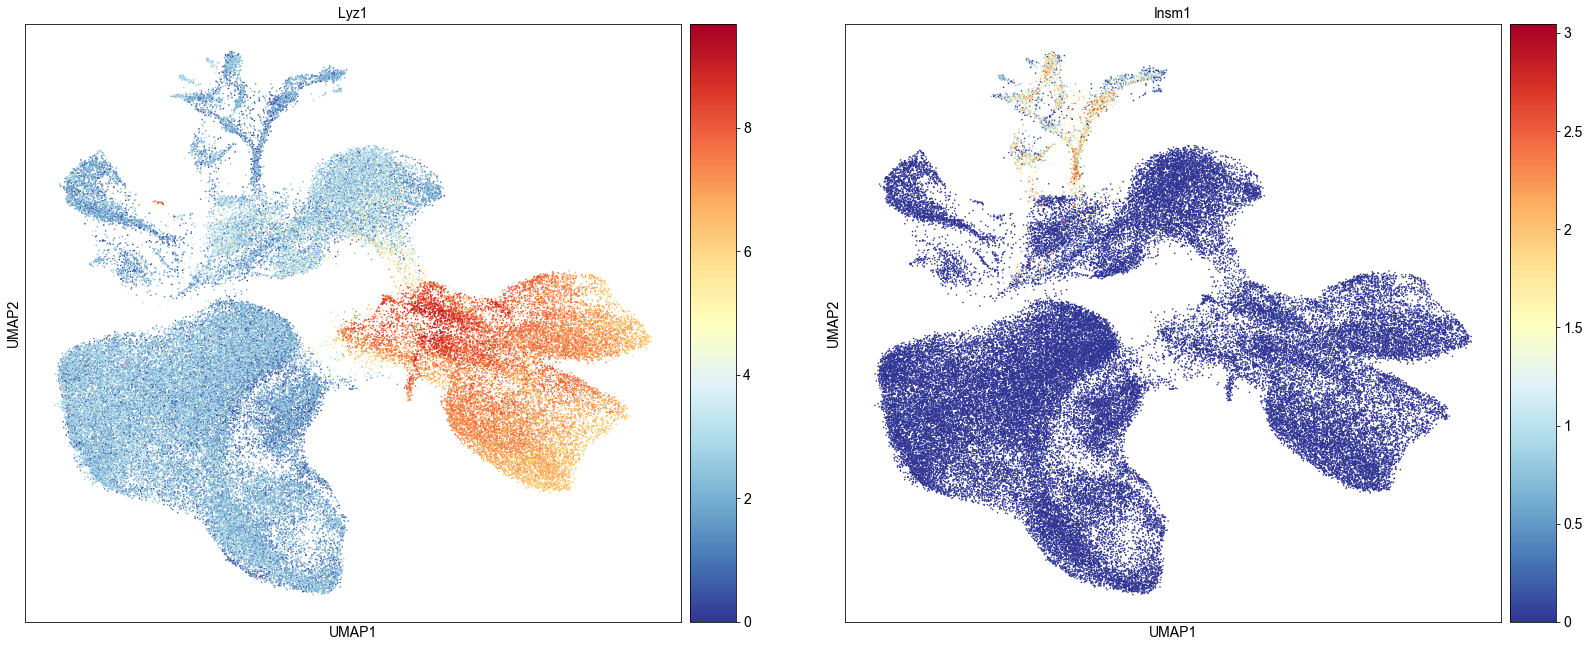

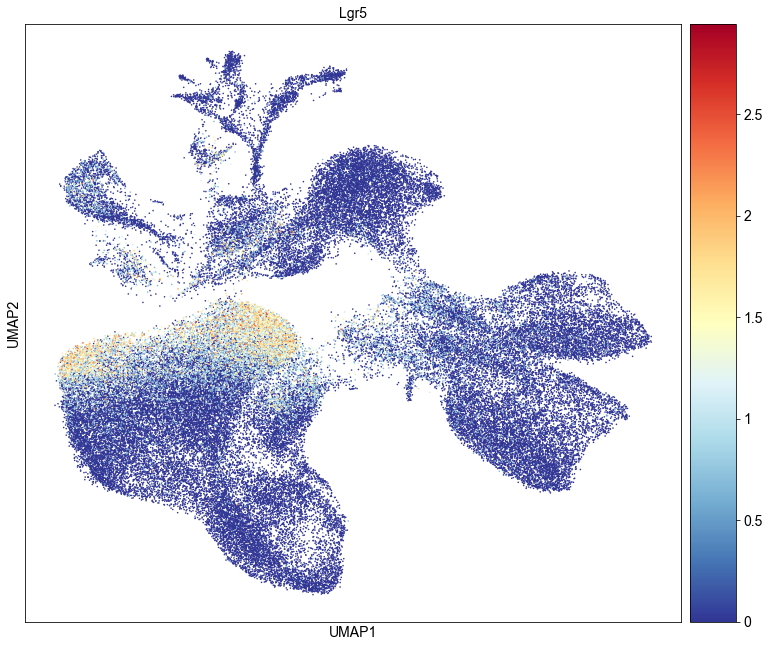

In [88]:
sc.pl.umap(adata_hvg, color=['sample', 'n_counts'], size=5)
sc.pl.umap(adata_hvg, color=['Lyz1', 'Insm1'], size=10)
sc.pl.umap(adata_hvg, color=['Lgr5'], size=10)

# Save to file

In [90]:
sc.write(adata=adata_hvg,filename= './../data/gut_AB_AL_log_cor_combat_normed.h5')